In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.signal import butter, filtfilt
from datetime import datetime

In [2]:
def high_pass(data):
    """
    Applies a high pass filter to the voltage data in the dataframe.

    Parameters:
    data: A Pandas dataframe containing the voltage data.

    Returns:
    A Pandas dataframe containing the flitered voltages of the two channels
    """
    # Define the cutoff frequency (in Hz) for the high pass filter
    cutoff_freq = 1

    # Define the filter order
    filter_order = 8

    # Define the sampling rate (in Hz) for the voltage data
    sampling_rate = 250

    # Define the voltage variable
    voltage_chan_1 = data.iloc[:, 0].values
    voltage_chan_2 = data.iloc[:, 1].values

    # Define the filter coefficients
    nyquist_freq = sampling_rate / 2
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    b, a = butter(filter_order, normalized_cutoff_freq, btype='highpass')

    # Apply the filter to the voltage data
    voltage_chan_1 = filtfilt(b, a, voltage_chan_1)
    voltage_chan_2 = filtfilt(b, a, voltage_chan_2)

    return pd.DataFrame({'FP1 (channel 1)': voltage_chan_1, 'FP2 (channel 2)': voltage_chan_2})


def low_pass(data):
    """
    Applies a low pass filter to the voltage data in a Pandas dataframe.

    Parameters:
    data: A Pandas dataframe containing the voltage data.

    Returns:
    A Pandas dataframe containing the flitered voltages of the two channels
    """
    # Define the cutoff frequency (in Hz) for the low pass filter
    cutoff_freq = 5

    # Define the filter order
    filter_order = 8

    # Define the sampling rate (in Hz) for the voltage data
    sampling_rate = 250

    # Define the voltage variable
    voltage_chan_1 = data.iloc[:, 0].values
    voltage_chan_2 = data.iloc[:, 1].values

    # Define the filter coefficients
    nyquist_freq = sampling_rate / 2
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    b, a = butter(filter_order, normalized_cutoff_freq, btype='lowpass')

    # Apply the filter to the voltage data
    voltage_chan_1 = filtfilt(b, a, voltage_chan_1)
    voltage_chan_2 = filtfilt(b, a, voltage_chan_2)

    return pd.DataFrame({'FP1 (channel 1)': voltage_chan_1, 'FP2 (channel 2)': voltage_chan_2})


def average_min_max(data):
    """
    Calculate the average minimum and maximum filtered and normalized voltage 
    value for channel 1 and 2 based on a manually set threashold.

    Parameters:
    data: A Pandas dataframe containing the filtered voltage data.

    Returns:
    min_1, min_2: averaged minimum value of channel 1 and 2.
    max_1, max_2: averaged maximum value of channel 1 and 2.
    """  
    min_1, max_1, num_min_1, num_max_1= 0, 0, 0, 0
    min_2, max_2, num_min_2, num_max_2= 0, 0, 0, 0
    voltage_chan_1 = data.iloc[:, 0].values
    voltage_chan_2 = data.iloc[:, 1].values

    for i in range(len(voltage_chan_1)):
        # Calculation for channel 1 based on manually set threashold
        if (voltage_chan_1[i] <= -100):
            min_1 += voltage_chan_1[i]
            num_min_1 += 1
        elif (voltage_chan_1[i] >= 70):
            max_1 += voltage_chan_1[i]
            num_max_1 += 1

        # Calculation for channel 2 based on manually set threashold
        if (voltage_chan_2[i] <= -100):
            min_2 += voltage_chan_2[i]
            num_min_2 += 1
        elif (voltage_chan_2[i] >= 70):
            max_2 += voltage_chan_2[i]
            num_max_2 += 1

    return (min_1 / num_min_1), (max_1 / num_max_1), (min_2 / num_min_2), (max_2 / num_max_2)


def preprocess(df):
    df = df.loc[6:,:]
    data = df.iloc[:,1:3]
    time = df.iloc[:, -2]

    # Visualize the raw eye blink data
    plt.plot(time, data.iloc[:, 0], label='chan_1')
    plt.plot(time, data.iloc[:, 1], label='chan_2')
    plt.title("Raw Data")
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

    
    filtered = high_pass(data)
    print("After applying high pass filter")
    # Visualize the data after applying the high pass filter
    plt.plot(time, filtered.iloc[:, 0], label='chan_1')
    plt.plot(time, filtered.iloc[:, 1], label='chan_2')
    plt.title("High-Passed Data")
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

    filtered = low_pass(filtered)
    print("After applying low pass filter")
    # Visualize the data after applying the low pass filter
    plt.plot(time, filtered.iloc[:, 0], label='chan_1')
    plt.plot(time, filtered.iloc[:, 1], label='chan_2')
    plt.title("Low-Passed Data")
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

    avg_min_1, avg_max_1, avg_min_2, avg_max_2 = average_min_max(filtered)
    print("Average minimum and maximum voltage values found for FP1 (channel 1): ", avg_min_1, avg_max_1)
    print("Average minimum and maximum voltage values found for FP2 (channel 2): ", avg_min_2, avg_max_2)

    return filtered

epoch_seconds = 5.2
epoch = int(epoch_seconds / 0.004)

def divide_dataset(data, time):
    num_epoch = math.ceil(len(time) / epoch)
    data_subsets = []
    time_subsets = []
    start = 0
    for i in range(num_epoch):
        if start + epoch >= len(time):
            data_subsets.append(data.iloc[start:,:])
            time_subsets.append(time[start:])       
        else:
            data_subsets.append(data.iloc[start:start + epoch,:])
            time_subsets.append(time[start:start + epoch])
            start = start + epoch
    return data_subsets, time_subsets

def svt(data, avg_min_1, avg_max_1, avg_min_2, avg_max_2):
    min_1, min_2 = np.min(data).values
    max_1, max_2 = np.max(data).values
    
    min_flag_1 = min_1 <= avg_min_1
    max_flag_1 = max_1 >= avg_max_1
    min_flag_2 = min_2 <= avg_min_1
    max_flag_2 = max_2 >= avg_max_1
    
    return min_flag_1 or max_flag_1 or min_flag_2 or max_flag_2

In [3]:
df = pd.read_csv('Subject_4\CSV\BrainFlow-RAW_2023-03-07_11-46-58_44.csv', delimiter='\t')

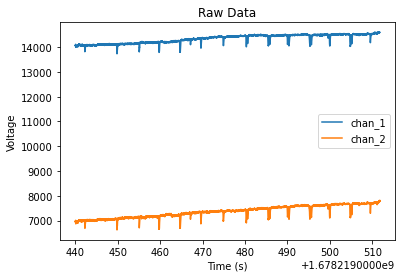

After applying high pass filter


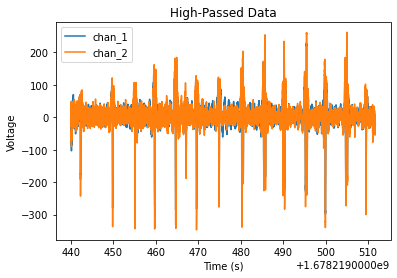

After applying low pass filter


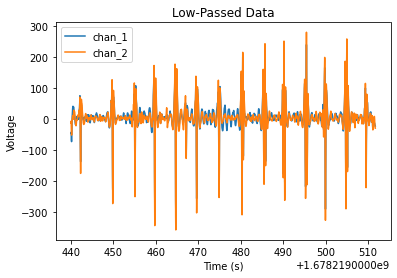

Average minimum and maximum voltage values found for FP1 (channel 1):  -177.08535903986277 111.23709702905228
Average minimum and maximum voltage values found for FP2 (channel 2):  -200.7044091942595 119.13608668299918


In [4]:
filtered = preprocess(df)

In [5]:
filtered

,FP1 (channel 1),FP2 (channel 2)
0,-45.784456,-12.848942
1,-45.235067,-11.820206
2,-44.741499,-10.854837
3,-44.316526,-9.973638
4,-43.972162,-9.196371
...,...,...
17953,-23.013345,-29.809603
17954,-23.056145,-29.915657
17955,-23.091917,-30.003708
17956,-23.121512,-30.076084


Single blink:


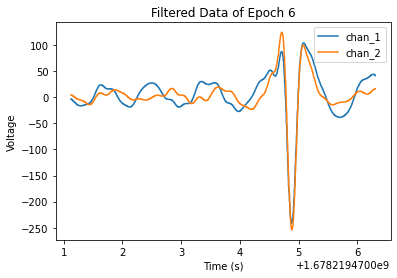

Double blink:


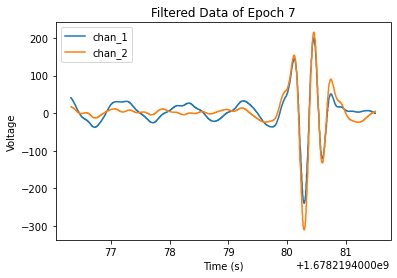

In [6]:
time = df.iloc[:, -2]
filtered_subset, time_subset = divide_dataset(filtered, time)
num_epoch = math.ceil(len(time) / epoch)

print("Single blink:")
for i in range(6,7): # change to (0,num_epoch + 1) to see plots of all epochs
    plt.plot(time_subset[i], filtered_subset[i]['FP1 (channel 1)'], label='chan_1')
    plt.plot(time_subset[i], filtered_subset[i]['FP2 (channel 2)'], label='chan_2')
    plt.title("Filtered Data of Epoch " + str(i))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

print("Double blink:")
for i in range(7,8): # change to (0,num_epoch + 1) to see plots of all epochs
    plt.plot(time_subset[i], filtered_subset[i]['FP1 (channel 1)'], label='chan_1')
    plt.plot(time_subset[i], filtered_subset[i]['FP2 (channel 2)'], label='chan_2')
    plt.title("Filtered Data of Epoch " + str(i))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

In [7]:
avg_min_1, avg_max_1, avg_min_2, avg_max_2 = average_min_max(filtered)
eye_blinks = []

for subset in filtered_subset:
    label = int(svt(subset, avg_min_1, avg_max_1, avg_min_2, avg_max_2))
    eye_blinks.append(label)
    
print("In " + str(len(eye_blinks)), "epochs, " + str(sum(eye_blinks)) + " epochs contain eye blinks:", eye_blinks, ", where 1 indicates an eye blink.")

In 14 epochs, 13 epochs contain eye blinks: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] , where 1 indicates an eye blink.
